https://www.clairvoyant.ai/blog/music-genre-classification-using-cnn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import time

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-11-13 15:22:47.880483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [3]:
df.shape

(9990, 60)

In [4]:
df.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [5]:
df = df.drop(labels='filename', axis=1)

In [6]:
audio_recording = 'genres_original/classical/classical.00050.wav'
data, sr = librosa.load(audio_recording)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [7]:
librosa.load(audio_recording, sr=45600)

(array([0.00281965, 0.00259183, 0.0014593 , ..., 0.01618489, 0.01366561,
        0.00691484], dtype=float32),
 45600)

In [8]:
import IPython
IPython.display.Audio(data, rate=sr)

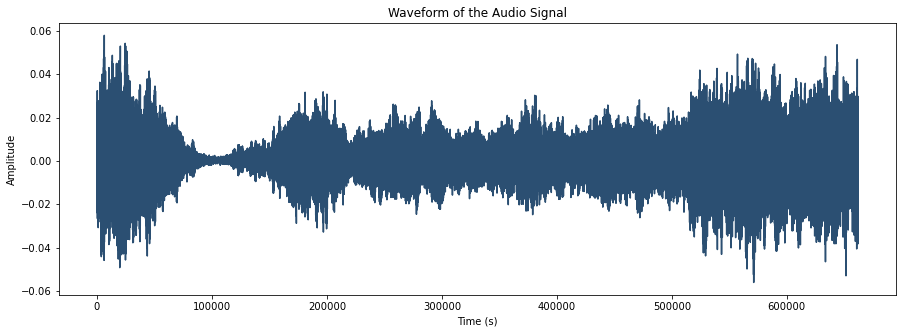

In [9]:
# Plot the waveform
plt.figure(figsize=(15, 5))
plt.plot(data, color='#2B4F72')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of the Audio Signal')
plt.show()

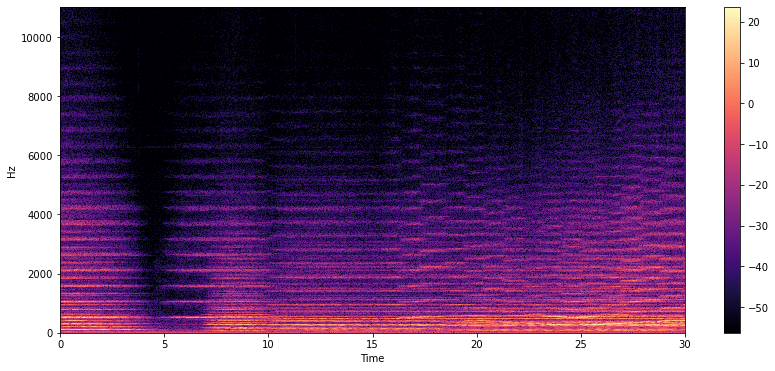

In [10]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

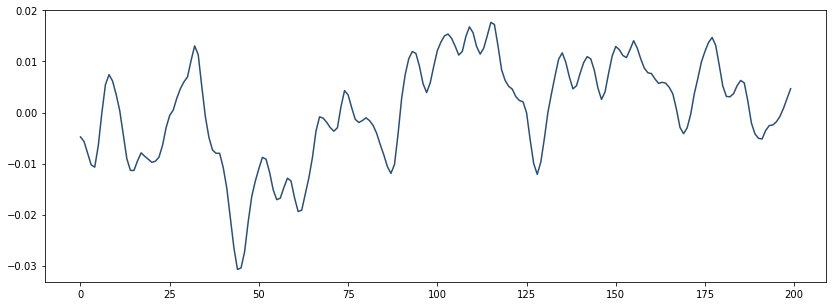

In [11]:
start = 1000
end = 1200
plt.figure(figsize=(14, 5))
plt.plot(data[start:end], color='#2B4F72')

In [12]:
zero_cross_rate = librosa.zero_crossings(data[start:end], pad=False)
print('The number of zero-crossings is :', sum(zero_cross_rate))

The number of zero-crossings is : 13


In [13]:
class_list = df.iloc[:, -1]
convertor = LabelEncoder()

In [14]:
y = convertor.fit_transform(class_list)
y

array([0, 0, 0, ..., 9, 9, 9])

In [15]:
print(df.iloc[:, :-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

In [16]:
fit = StandardScaler()
X = fit.fit_transform(np.array(df.iloc[:, :-1], dtype =float))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

len(y_train)

7992

In [18]:
len(y_test)

1998

In [19]:
# Reshape data for CNN
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Build CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_cnn, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Predict labels for the validation set
y_pred = np.argmax(model.predict(X_test), axis=1)

# Calculate metrics
	
#print('Accuracy:' % accuracy_score(y_test, y_pred))
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


Epoch 1/20
125/125 [==============================] - 2s 8ms/step - loss: 1.2812 - accuracy: 0.5562 - val_loss: 0.9794 - val_accuracy: 0.6627
Epoch 2/20
125/125 [==============================] - 1s 10ms/step - loss: 0.9103 - accuracy: 0.6876 - val_loss: 0.8438 - val_accuracy: 0.7157
Epoch 3/20
125/125 [==============================] - 1s 12ms/step - loss: 0.7727 - accuracy: 0.7350 - val_loss: 0.7864 - val_accuracy: 0.7352
Epoch 4/20
125/125 [==============================] - 1s 8ms/step - loss: 0.6915 - accuracy: 0.7591 - val_loss: 0.7437 - val_accuracy: 0.7367
Epoch 5/20
125/125 [==============================] - 1s 9ms/step - loss: 0.6200 - accuracy: 0.7858 - val_loss: 0.6636 - val_accuracy: 0.7653
Epoch 6/20
125/125 [==============================] - 1s 6ms/step - loss: 0.5563 - accuracy: 0.8102 - val_loss: 0.6002 - val_accuracy: 0.7958
Epoch 7/20
125/125 [==============================] - 1s 6ms/step - loss: 0.5069 - accuracy: 0.8236 - val_loss: 0.5954 - val_accuracy: 0.7983
Epoc

In [20]:
# Print metrics
score = model.evaluate(X_test, y_test, verbose=0)
print('CNN Accuracy:', score[1])
print('CNN Precision: {:.2f}'.format(precision))
print('CNN Recall: {:.2f}'.format(recall))
print('CNN F1 Score: {:.2f}'.format(f1))

CNN Accuracy: 0.8613613843917847
CNN Precision: 0.86
CNN Recall: 0.86
CNN F1 Score: 0.86


In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=128)
print("The test loss is: ", test_loss)
print("\n The Best test Accuracy is: ", test_acc*100)

16/16 [==============================] - 0s 3ms/step - loss: 0.4329 - accuracy: 0.8614
The test loss is:  0.43285447359085083

 The Best test Accuracy is:  86.13613843917847


In [22]:
# Build CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Time the execution of the CNN Model
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print('Execution time for CNN Model: ', end_time - start_time, 'seconds')


250/250 [==============================] - 2s 7ms/step - loss: 1.1809 - accuracy: 0.5842
Execution time for CNN Model:  2.43710994720459 seconds


In [23]:
# Build SVM model
svm_model = SVC(kernel='rbf', random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predict labels for the test set
y_pred_svm = svm_model.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)


In [24]:
# Calculate metrics
	
#print('Accuracy:' % accuracy_score(y_test, y_pred))
svm_precision = precision_score(y_test, y_pred_svm, average='weighted')
svm_recall = recall_score(y_test, y_pred_svm, average='weighted')
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')


In [25]:
# Print metrics
# Print accuracy
print(f"SVM Accuracy: {accuracy_svm}")
print('SVM Precision: {:.2f}'.format(svm_precision))
print('SVM Recall: {:.2f}'.format(svm_recall))
print('SVM F1 Score: {:.2f}'.format(svm_f1))

SVM Accuracy: 0.8558558558558559
SVM Precision: 0.86
SVM Recall: 0.86
SVM F1 Score: 0.86


In [26]:
import joblib

# Assuming you have a trained model called 'svm_model'
# and a trained scaler called 'scaler'
# Replace 'svm_model' and 'scaler' with your actual variable names

# Save the SVM model
joblib.dump(svm_model, 'svm_model.pkl')

# Save the scaler
joblib.dump(fit, 'scaler.pkl')


['scaler.pkl']

In [27]:
# Define SVM model
svm_model = SVC()

# Time the execution of the SVM Model
start_time = time.time()
svm_model.fit(X_train, y_train)
end_time = time.time()
print('Execution time for SVM Model: ', end_time - start_time, 'seconds')


Execution time for SVM Model:  1.7552480697631836 seconds


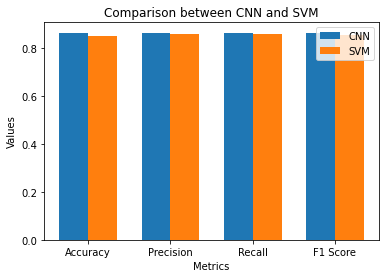

In [28]:

# Set values for the bar graph
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
cnn_values = [0.86, precision, recall, f1]
svm_values = [0.85, svm_precision, svm_recall, svm_f1]

# Set positions and width for bars
bar_width = 0.35
bar_positions = np.arange(len(metrics))

# Create bar graph
plt.bar(bar_positions - bar_width / 2, cnn_values, bar_width, label='CNN')
plt.bar(bar_positions + bar_width / 2, svm_values, bar_width, label='SVM')

# Set labels and legend
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(bar_positions, metrics)
plt.title('Comparison between CNN and SVM')
plt.legend()

# Show the graph
plt.show()

In [29]:
# Random Forest Model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

In [30]:
# Calculate metrics
	
#print('Accuracy:' % accuracy_score(y_test, y_pred))
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')


In [31]:
# Print metrics
# Print accuracy
print(f"Random Forest Accuracy: {rf_accuracy}")
print('Random Forest Precision: {:.2f}'.format(rf_precision))
print('Random Forest Recall: {:.2f}'.format(rf_recall))
print('Random Forest F1 Score: {:.2f}'.format(rf_f1))

Random Forest Accuracy: 0.8683683683683684
Random Forest Precision: 0.87
Random Forest Recall: 0.87
Random Forest F1 Score: 0.87


In [32]:
# Define Random Forest model
rfc = RandomForestClassifier(n_estimators=100)

# Time the execution of the SVM Model
start_time = time.time()
rfc.fit(X_train, y_train)
end_time = time.time()
print('Execution time for Random Forest Model: ', end_time - start_time, 'seconds')


Execution time for Random Forest Model:  4.378956079483032 seconds


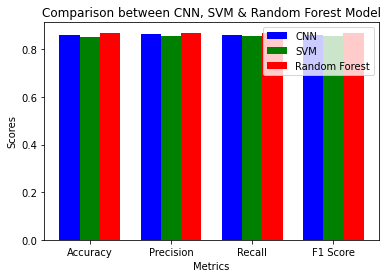

In [33]:

# Assuming you have the scores for CNN, SVM, and Random Forest
cnn_scores = [0.86, precision, recall, f1]
svm_scores = [0.85, svm_precision, svm_recall, svm_f1]
rf_scores = [0.87, rf_precision, rf_recall, rf_f1]

# Set labels and positions
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(labels))
bar_width = 0.25

# Create bar graph
plt.bar(x - bar_width, cnn_scores, bar_width, label='CNN', color='b')
plt.bar(x, svm_scores, bar_width, label='SVM', color='g')
plt.bar(x + bar_width, rf_scores, bar_width, label='Random Forest', color='r')

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison between CNN, SVM & Random Forest Model')
plt.xticks(x, labels)
plt.legend()

# Show the graph
plt.show()


In [34]:
dataset = pd.read_csv('features_3_sec.csv')

In [35]:
import joblib

# Assuming you used joblib to save your model and scaler
# Load pre-trained SVM model
svm_model = joblib.load('svm_model.pkl')

# Load pre-trained scaler
scaler = joblib.load('scaler.pkl')

# Map numerical labels to genre names
label_to_genre = {
    0: 'blues',
    1: 'classical',
    2: 'country',
    3: 'disco',
    4: 'hiphop',
    5: 'jazz',
    6: 'metal',
    7: 'pop',
    8: 'reggae',
    9: 'rock'
}

# Now, you can use the loaded model, scaler, and label_to_genre mapping in your function
def find_genre(audio_file):
    # Assuming you have the pre-trained SVM model and dataset loaded

    # Check if the audio_file exists in the dataset
    if audio_file.strip() not in dataset['filename'].str.strip().values:
        print(f"Error: Music file '{audio_file}' not found in the dataset.")
        return

    # Select row corresponding to the audio file
    row = dataset.loc[dataset['filename'] == audio_file.strip()]

    # Extract numerical features
    features = row.iloc[:, :-1].select_dtypes(include='number').values

    # Scale features using pre-trained scaler
    scaled_features = scaler.transform(features)

    # Predict genre using pre-trained SVM model
    predicted_genre_label = svm_model.predict(scaled_features)[0]

    # Map numerical label to genre name
    predicted_genre = label_to_genre.get(predicted_genre_label, 'Unknown')

    # Print the predicted genre
    print(f"Predicted genre for '{audio_file}': {predicted_genre}")

# Example usage
find_genre('reggae.00003.0.wav')


Predicted genre for 'reggae.00003.0.wav': reggae
